In [279]:
%matplotlib inline

import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# from xgboost.sklearn import XGBClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [280]:
# Plot a confusion matrix
def plot_cm(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred)
    fig = plt.figure(figsize = (5,5))
    sns.set(font_scale = 1.25)
    sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = ',.0f', annot_kws = {'size': 14})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show();

# Model diagnostics
def model_results(y, y_pred, y_pred_proba):
    print(metrics.classification_report(y, y_pred))
    print('Area under ROC:', metrics.roc_auc_score(y, y_pred_proba[:, 1]))
    plot_cm(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    
# Cross-validation model fitting and diagnostics
def model_results_cv(X, y, classifier):
    y_pred = cross_val_predict(classifier, X, y, cv = 10)
    y_pred_proba = cross_val_predict(classifier, X, y, cv = 10, method='predict_proba')
    model_results(y, y_pred, y_pred_proba)

In [281]:
wine = pd.read_csv('C:/Projects/wining-and-mining/data/raw/winemag-data-130k-v2.csv', index_col = 0)

# Wrangling

In [282]:
# Extract year from title

# regex to extract date (matching wines from 20th and 21st century)
wine['year'] = wine['title'].apply(lambda x: re.search(r'(19|20)[0-9]{2}', x))  # _sre.SRE_Match object returned
year_exists = pd.notnull(wine['year'])  # Find where there is a match (no match signified by `NaN`)
wine.loc[year_exists, 'year'] = wine.loc[year_exists, 'year'].apply(lambda x: x.group(0))  # Extract year where there is a match
wine = wine[~wine['year'].isnull()]
wine['year'] = wine['year'].astype(int)

In [283]:
wine = wine.dropna(axis = 0, how = 'any') 

In [284]:
numeric_cols = wine._get_numeric_data().columns
categoric_cols = [c for c in wine.columns if c not in numeric_cols]

In [285]:
wine.duplicated().value_counts()
wine[wine.duplicated(keep=False)].sort_values('title').head(6)
wine = wine.drop_duplicates(keep='first')
wine[wine.duplicated(subset='title', keep=False)].sort_values('title').shape
wine = wine.drop_duplicates(subset='title', keep=False)

False    20171
True      1876
dtype: int64

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
66222,US,"Merlot, Cabernet and Syrah form the core of th...",Hot To Trot,86,10.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,14 Hands 2011 Hot To Trot Red (Columbia Valley...,Red Blend,14 Hands,2011
100235,US,"Merlot, Cabernet and Syrah form the core of th...",Hot To Trot,86,10.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,14 Hands 2011 Hot To Trot Red (Columbia Valley...,Red Blend,14 Hands,2011
57235,US,Dried herb and wood spice aromas are followed ...,The Reserve,90,30.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,14 Hands 2013 The Reserve Cabernet Sauvignon (...,Cabernet Sauvignon,14 Hands,2013
56652,US,Dried herb and wood spice aromas are followed ...,The Reserve,90,30.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,14 Hands 2013 The Reserve Cabernet Sauvignon (...,Cabernet Sauvignon,14 Hands,2013
26499,US,"Aromas are light, with notes of matchstick, he...",Limited Release Kentucky Derby,87,12.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,14 Hands 2014 Limited Release Kentucky Derby R...,Red Blend,14 Hands,2014
8183,US,"Aromas are light, with notes of matchstick, he...",Limited Release Kentucky Derby,87,12.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,14 Hands 2014 Limited Release Kentucky Derby R...,Red Blend,14 Hands,2014


(66, 14)

# Value for money wines

## Simple ratio of score to price

One way to think of value for money, is to divide the price of the wine into the score. The higher the ration of score to price, the greater the value for money. We can then figure out what the best value for money wine is by:
+ price range
+ country
+ winery
+ variety

In [286]:
wine['points_per_dollar'] = wine['points']/wine['price'] 

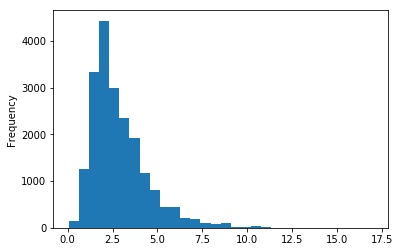

In [287]:
wine['points_per_dollar'].plot.hist(bins=30)

`Points per dollar` has a right-ward skew but looks a lot more normal when logged.

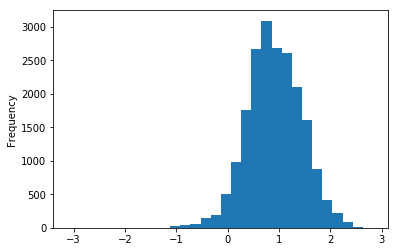

In [288]:
np.log(wine['points_per_dollar']).plot.hist(bins=30)

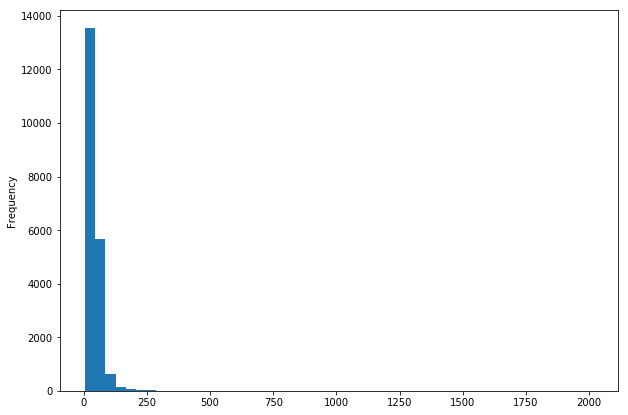

In [289]:
fig, ax = plt.subplots(figsize = (10, 7))
wine['price'].plot.hist(bins=50)

In [290]:
price_iqr = wine['price'].quantile(0.75) - wine['price'].quantile(0.25)
price_upper_bound = wine['price'].quantile(0.75) + price_iqr * 1.5
wine['is_outlier'] = np.where((wine['price']>price_upper_bound), 1, 0)
outlier_counts = wine['is_outlier'].value_counts()
price_upper_bound
print('Proportion of wines that are deemed outliers: {0:.2%}'.format(outlier_counts[1]/outlier_counts.sum()))

87.5

Proportion of wines that are deemed outliers: 4.49%


In [291]:
wine = wine.loc[wine['is_outlier']==0]

count    19202.000000
mean        37.980367
std         17.262024
min          5.000000
25%         25.000000
50%         35.000000
75%         50.000000
max         87.000000
Name: price, dtype: float64

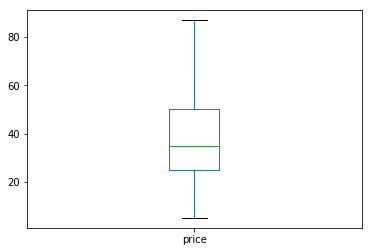

In [292]:
wine['price'].describe()
wine['price'].plot.box()


In [334]:
def normalise(series):
    return (series - series.mean()) / (series.max() - series.min())
wine['normalised_price'] = normalise(wine['price'])
wine['normalised_points'] = normalise(wine['points'])
wine['normalised_points_per_dollar'] = wine['normalised_points']/wine['normalised_price']

def scale(series):
    return (series - series.min()) / (series.max() - series.min())
wine['scaled_price'] = scale(wine['price'])
wine['scaled_points'] = scale(wine['points'])
wine['scaled_points_per_dollar'] = wine['scaled_points']/np.log1p(wine['price'])




In [335]:
wine['log_price'] = np.log(wine['price'])
wine['log_price_cat'] = wine['log_price'].round()

wine['log_points'] = np.log(wine['points'])
wine['log_points_cat'] = wine['log_points'].round()

wine['log_cat_point_per_dollar'] = wine['log_points_cat'] / wine['log_price_cat'] 

In [336]:
list(range(wine['price'].min().astype(int), wine['price'].max().astype(int), 5))

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]

In [338]:
wine['price_cat'].value_counts()

(25.0, 30.0]     2392
(20.0, 25.0]     2274
(35.0, 40.0]     2074
(15.0, 20.0]     1990
(30.0, 35.0]     1831
(45.0, 50.0]     1794
(40.0, 45.0]     1661
(10.0, 15.0]     1050
(50.0, 55.0]      946
(55.0, 60.0]      913
(60.0, 65.0]      686
(70.0, 75.0]      449
(65.0, 70.0]      368
(4.999, 10.0]     263
(80.0, 85.0]      260
(75.0, 80.0]      242
nan                 9
Name: price_cat, dtype: int64

In [339]:
wine.loc[wine['price_cat'] == 'nan']

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,normalised_points_per_dollar,scaled_price,scaled_points,scaled_points_per_dollar,log_price,log_price_cat,log_points,log_points_cat,log_cat_point_per_dollar,price_cat
31419,US,"This is a stunning, vibrantly robust and inten...",Relentless,95,87.0,California,Napa Valley,Napa,Virginie Boone,@vboone,...,0.462442,1.000000,0.75,0.167510,4.465908,4.0,4.553877,5.0,1.25,nan
33394,US,"Homer is the estate reserve, wood-tank ferment...",Shea Vineyard Homer,95,86.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,...,0.472072,0.987805,0.75,0.167939,4.454347,4.0,4.553877,5.0,1.25,nan
34094,US,"Homer is the reserve cuvée, a barrel-selection...",Homer,94,86.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,...,0.386690,0.987805,0.70,0.156743,4.454347,4.0,4.543295,5.0,1.25,nan
50360,US,Named for an energy industry phrase meaning an...,Contango,92,86.0,California,Happy Canyon of Santa Barbara,Central Coast,Matt Kettmann,@mattkettmann,...,0.215927,0.987805,0.60,0.134351,4.454347,4.0,4.521789,5.0,1.25,nan
59027,US,Earthy aromas of clay and wet slate meet with ...,Niclaire,91,87.0,California,California,California Other,Matt Kettmann,@mattkettmann,...,0.127882,1.000000,0.55,0.122841,4.465908,4.0,4.510860,5.0,1.25,nan
74468,US,"This full-bodied, voluptuous wine is spicy in ...",Lost Vineyard,91,86.0,California,Napa Valley,Napa,Virginie Boone,@vboone,...,0.130545,0.987805,0.55,0.123155,4.454347,4.0,4.510860,5.0,1.25,nan
79074,US,"From some of the property's oldest vines, this...",Three Corner,94,86.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,...,0.386690,0.987805,0.70,0.156743,4.454347,4.0,4.543295,5.0,1.25,nan
97956,US,"One of the winery's luxury-level releases, thi...",Limited Resource Estate Grown,88,87.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,...,-0.123038,1.000000,0.40,0.089339,4.465908,4.0,4.477337,4.0,1.00,nan
120992,US,This vineyard-designate offers a wealth and br...,River Block,95,86.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,...,0.472072,0.987805,0.75,0.167939,4.454347,4.0,4.553877,5.0,1.25,nan


In [340]:
wine['price_cat'] = pd.cut(wine['price'], range(wine['price'].min().astype(int), wine['price'].max().astype(int), 5), include_lowest=True).astype(str)

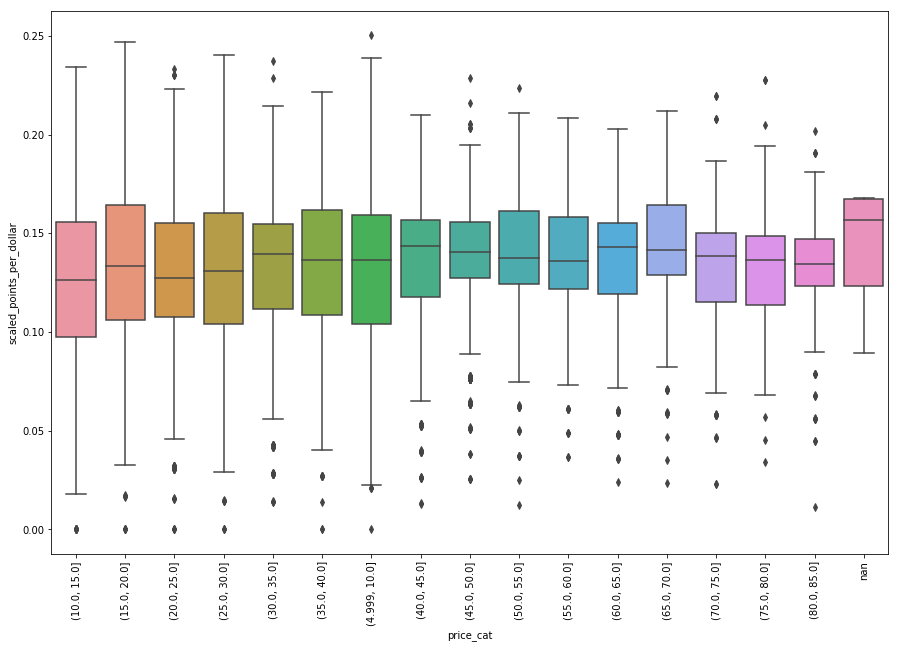

In [341]:
fig, ax = plt.subplots(figsize = (15, 10))
s = sns.boxplot(y=wine['scaled_points_per_dollar'], x=wine['price_cat'], order=sorted(wine['price_cat'].unique()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();

In [190]:
wine.plot.scatter(y='scaled_points_per_dollar', x='price', c='points', colormap='jet', figsize=(20,15), sharex=False)
plt.show()

wine.plot.scatter(y='scaled_points_per_dollar', x='points', c='price', colormap='jet', figsize=(20,15), sharex=False)
plt.show()


ValueError: scatter requires x column to be numeric

In [39]:
wine.loc[(wine['normalised_points_per_dollar']>-5) & (wine['normalised_points_per_dollar']<5)]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,points_per_dollar,log_price,log_price_cat,normalised_price,normalised_points,normalised_points_per_dollar
99,US,This blends 20% each of all five red-Bordeaux ...,Intreccio Library Selection,88,75.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Soquel Vineyards 2013 Intreccio Library Select...,Bordeaux-style Red Blend,Soquel Vineyards,2013,1.173333,4.317488,4.0,0.016456,-0.079689,-4.842482
144,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Napa,Virginie Boone,@vboone,Terra Valentine 2013 K Block Cabernet Sauvigno...,Cabernet Sauvignon,Terra Valentine,2013,1.070588,4.442651,4.0,0.021436,0.070311,3.279985
168,US,"A fairly elegant expression of the variety, th...",Rector Creek Vineyard,91,95.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Duckhorn 2012 Rector Creek Vineyard Merlot (Na...,Merlot,Duckhorn,2012,0.957895,4.553877,5.0,0.026416,0.070311,2.661635
198,US,"This is a soft, well-crafted wine from the eas...",Four Soil Mélange,90,60.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Sequum 2013 Four Soil Mélange Cabernet Sauvign...,Cabernet Sauvignon,Sequum,2013,1.500000,4.094345,4.0,0.008986,0.020311,2.260244
199,US,"This is a beatifully balanced, not-too-full-bo...",Rising Starr Estate Bottled,90,28.0,California,Nevada County,Sierra Foothills,Jim Gordon,@gordone_cellars,Sierra Starr 2014 Rising Starr Estate Bottled ...,Cabernet Franc,Sierra Starr,2014,3.214286,3.332205,3.0,-0.006950,0.020311,-2.922378
204,US,This bottling belongs to a series of wines fro...,Gesture,90,30.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,J. Lohr 2014 Gesture G-S-M (Paso Robles),G-S-M,J. Lohr,2014,3.000000,3.401197,3.0,-0.005954,0.020311,-3.411241
205,US,"Rich honeysuckle, marzipan and oak aromas meet...",October Night,90,25.0,California,Arroyo Seco,Central Coast,Matt Kettmann,@mattkettmann,J. Lohr 2015 October Night Chardonnay (Arroyo ...,Chardonnay,J. Lohr,2015,3.600000,3.218876,3.0,-0.008444,0.020311,-2.405321
207,US,Juicy and austere in understated waves of cran...,Home Ranch Teldeschi Vineyards Century Old Vine,90,32.0,California,Dry Creek Valley,Sonoma,Virginie Boone,@vboone,Del Carlo Winery 2014 Home Ranch Teldeschi Vin...,Zinfandel,Del Carlo Winery,2014,2.812500,3.465736,3.0,-0.004958,0.020311,-4.096516
362,US,As impressive as the woman—a pioneer in the Na...,Jamie,95,200.0,California,Diamond Mountain District,Napa,Virginie Boone,@vboone,J. Davies 2012 Jamie Cabernet Sauvignon (Diamo...,Cabernet Sauvignon,J. Davies,2012,0.475000,5.298317,5.0,0.078707,0.270311,3.434383
421,US,"All varietal, this wine is a blend of fruit fr...",Confidential Source,89,30.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Guardian 2013 Confidential Source Merlot (Colu...,Merlot,Guardian,2013,2.966667,3.401197,3.0,-0.005954,-0.029689,4.986335


In [95]:
price_ranges = [5.0, 25.0, 36.0, 50.0, 2013.0]
labels = ['5-25', '25-36', '36-50', '50-2013']
wine['price_range'] = pd.cut(wine['price'], bins=price_ranges, include_lowest=True)

In [92]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,points_per_dollar,price_range
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,1.338462,50-2013
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,2011,4.578947,5-25
23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi,2011,3.954545,5-25
25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,2011,1.260870,50-2013
35,US,As with many of the Erath 2010 vineyard design...,Hyland,86,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath,2010,1.720000,36-50


In [96]:
wine['price_range'].unique()
wine.loc[wine['price_range'] == pd.Interval(left=4.999, right=25)].head()

[(50.0, 2013.0], (4.999, 25.0], (36.0, 50.0], (25.0, 36.0]]
Categories (4, interval[float64]): [(4.999, 25.0] < (25.0, 36.0] < (36.0, 50.0] < (50.0, 2013.0]]

In [109]:
for r in sorted(wine['price_range'].unique()):
    print('Price range: {0}'.format(r))
    wine.loc[wine['price_range']==r, 
             ['title', 'points_per_dollar', 'points', 'price']].sort_values('points_per_dollar', ascending=0).head(10)

Price range: (4.999, 25.0]


,title,points_per_dollar,points,price
8428,Earth's Harvest 2014 Organic Grapes Chardonnay...,17.000000,85,5.0
63697,Hogue 2008 Red Table Wine Red (Columbia Valley...,12.714286,89,7.0
49652,Kiona 1998 Late Harvest White Riesling (Yakima...,12.571429,88,7.0
49653,Kiona 1999 Late Harvest Muscat (Yakima Valley),12.571429,88,7.0
11809,CK Mondavi 2014 Willow Springs Pinot Grigio (C...,12.285714,86,7.0
80305,CK Mondavi 2014 Willow Springs Sauvignon Blanc...,12.142857,85,7.0
112286,CK Mondavi 2012 Scarlet Five Wildcreek Canyon ...,12.142857,85,7.0
12364,CK Mondavi 2013 Wildcreek Canyon Cabernet Sauv...,12.142857,85,7.0
19134,Columbia Winery 2000 Cellarmaster's Riesling (...,11.714286,82,7.0
26101,Snoqualmie 2006 Winemaker's Select Riesling (C...,11.375000,91,8.0


Price range: (25.0, 36.0]


,title,points_per_dollar,points,price
84832,Limerick Lane 2015 Grenache Rosé (Russian Rive...,3.615385,94,26.0
8556,Stolo 2014 Estate Chardonnay (San Luis Obispo ...,3.576923,93,26.0
118094,Ruby Hill Winery 2014 Reserve Collection Chard...,3.576923,93,26.0
29962,Kokomo 2013 Cuvée Red (Sonoma County),3.576923,93,26.0
104259,Kokomo 2014 Cuvée Red (Sonoma County),3.576923,93,26.0
117119,Skinner 2013 Seven Generations White (El Dorado),3.576923,93,26.0
37751,Michael David 2014 Earthquake Petite Sirah (Lodi),3.576923,93,26.0
46112,Joseph Swan Vineyards 2015 Catie's Corner Viog...,3.576923,93,26.0
124302,Melville 2013 Estate Chardonnay (Sta. Rita Hills),3.576923,93,26.0
129051,Kynsi 2013 Bien Nacido Vineyard Chardonnay (Sa...,3.576923,93,26.0


Price range: (36.0, 50.0]


,title,points_per_dollar,points,price
41403,Guardian 2011 The Wanted Red (Columbia Valley ...,2.540541,94,37.0
4634,Elyse 2012 York Creek Vineyard Petite Sirah (S...,2.540541,94,37.0
82820,Trisaetum 2015 Estates Reserve Riesling (Willa...,2.526316,96,38.0
9380,Fess Parker 2014 Bien Nacido Vineyard Chardonn...,2.513514,93,37.0
46688,Sheldon 2015 The Red Hat Old Vine Field Blend ...,2.513514,93,37.0
31957,L'Ecole No. 41 2008 Seven Hills Vineyard Estat...,2.513514,93,37.0
40638,L'Ecole No. 41 2009 Seven Hills Vineyard Estat...,2.513514,93,37.0
88173,Fess Parker 2013 Ashley's Chardonnay (Sta. Rit...,2.513514,93,37.0
103861,Patricia Green Cellars 2015 Freedom Hill Viney...,2.513514,93,37.0
88174,Fess Parker 2013 Bien Nacido Vineyard Chardonn...,2.513514,93,37.0


Price range: (50.0, 2013.0]


,title,points_per_dollar,points,price
9898,Roark Wine Co. 2014 Sanford & Benedict Vineyar...,1.846154,96,52.0
125848,Betz Family 2009 Clos de Betz Red Wine Red (Co...,1.826923,95,52.0
65947,Foxen 2015 John Sebastiano Vineyard Pinot Noir...,1.826923,95,52.0
84823,Roar 2014 Sierra Mar Vineyard Pinot Noir (Sant...,1.826923,95,52.0
98382,Williams Selyem 2012 Eastside Road Neighbors P...,1.826923,95,52.0
33798,The Calling 2014 Sullivan Vineyard Dutton Ranc...,1.823529,93,51.0
101579,Andrew Will 2007 Ciel du Cheval Vineyard Red W...,1.811321,96,53.0
72749,Brick House 2014 Les Dijonnais Pinot Noir (Rib...,1.807692,94,52.0
41387,Sleight of Hand 2011 The Illusionist Cabernet ...,1.807692,94,52.0
103180,Shafer 2013 Red Shoulder Ranch Chardonnay (Car...,1.807692,94,52.0


### Country

### Variety

### Winery

## Regression model to predict price and then flag wines that have prices lower than expected

# Variation between raters

+ Do raters rate the same wines differently? 
+ Do some raters have systematic biases towards specific countries, wineries, or varieties?

# Reverse-engineer descriptions of top wines

Use a naive bases binomial classifier to work out which words in descriptions are associated with high-scoring wines. We can then construct our own descriptions for high-scoring wines and see what our model would predict the scores to be.

# Preprocess data

In [10]:
y = wine['excellent+']
X = wine.drop('excellent+', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Modelling

In [ ]:
data = wine[['excellent+', 'country', 'variety', 'year']]
data = pd.get_dummies(data, columns = ['country', 'variety'])

X = data.drop('excellent+', axis = 1)
y = data['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegressionCV(random_state = 0, cv = 10)

X_train.shape
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(classifier.fit(X_train, y_train), prefit = True)
X_train_selected = model.transform(X_train)
X_train_selected.shape
X_test_selected = X_test.loc[:, model.get_support()]

# clf = Pipeline([
#   ('feature_selection', SelectFromModel(LogisticRegressionCV(random_state = 0, cv = 10))),
#   ('classification', LogisticRegressionCV())
# ])
# clf.fit(X_train, y_train)
classifier = LogisticRegression(random_state = 0)
y_pred = cross_val_predict(classifier, X_test_selected, y_test, cv = 10)
y_pred_probs = cross_val_predict(classifier, X_test_selected, y_test, cv = 10, method='predict_proba')

print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))


In [ ]:
data = wine[['excellent+', 'log_price', 'country', 'variety', 'year']]
data = pd.get_dummies(data, columns = ['country', 'variety'])

X = data.drop('excellent+', axis = 1)
y = data['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegression(random_state = 0)
y_pred = cross_val_predict(classifier, X_train, y_train, cv = 10)
y_pred_probs = cross_val_predict(classifier, X_train, y_train, cv = 10, method='predict_proba')

print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))

# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# y_pred_proba = classifier.predict_proba(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(metrics.classification_report(y_test, y_pred))
# print(metrics.accuracy_score(y_test, y_pred))
# print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))


In [ ]:
model = classifier.fit(X_train, y_train)
exp_coef = pd.DataFrame({'exp_coef': np.exp(model.coef_[0])}, index = X.columns).sort_values('exp_coef', ascending = 0)
exp_coef.head(10)          
exp_coef.tail(10) 

In [ ]:
data2 = wine[['excellent+', 'log_price']]

X2 = data2.drop('excellent+', axis = 1)
y = data2['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegression(random_state = 0)
y_pred2 = cross_val_predict(classifier, X2, y, cv = 10)
y_pred_probs2 = cross_val_predict(classifier, X2, y, cv = 10, method='predict_proba')
classifier.fit(X_train, y_train)
# y_pred_probs = classifier.predict(X_test)

print(confusion_matrix(y, y_pred2))
print(metrics.classification_report(y, y_pred2))
print(metrics.accuracy_score(y, y_pred2))
print(metrics.roc_auc_score(y, y_pred_probs2[:, 1]))

## Use wine description to predict score

In [11]:
# Compute word counts
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train['description'])
X_test_vec = vectorizer.transform(X_test['description'])

             precision    recall  f1-score   support

          0       0.86      0.82      0.84     60658
          1       0.72      0.78      0.75     36820

avg / total       0.81      0.80      0.81     97478

Area under ROC: 0.882017501387


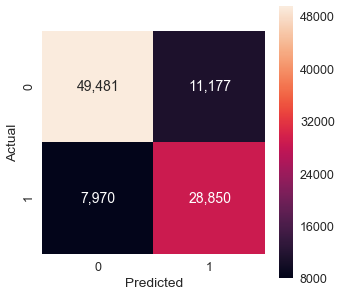

In [12]:
# Fit a naive bayes model to the training data.
nb_classifier = MultinomialNB()
model_results_cv(X_train_vec, y_train, nb_classifier)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

             precision    recall  f1-score   support

          0       0.86      0.82      0.84     20268
          1       0.72      0.79      0.75     12225

avg / total       0.81      0.81      0.81     32493

Area under ROC: 0.883305043703


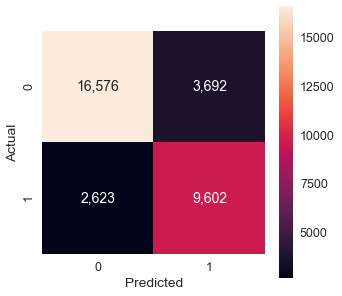

In [13]:
nb_classifier.fit(X_train_vec, y_train)
y_predict = nb_classifier.predict(X_test_vec)
y_predict_proba = nb_classifier.predict_proba(X_test_vec)
model_results(y_test, y_predict, y_predict_proba)

In [38]:
pd.DataFrame({'y_predict': y_predict, 
              'y_predict_proba': y_predict_proba[:, 0]})

,y_predict,y_predict_proba
0,0,1.000000e+00
1,1,1.044344e-02
2,0,9.983053e-01
3,1,4.211216e-01
4,0,9.501149e-01
5,0,9.998989e-01
6,0,9.756564e-01
7,0,8.304256e-01
8,0,7.174586e-01
9,0,9.997202e-01


In [53]:
y_test.head()

70354     0
4473      1
59653     0
107856    1
64547     0
Name: excellent+, dtype: int64

In [15]:
incorrectly_classified_idx = (y_test != y_predict).tolist()
incorrectly_classified = pd.concat([X_test.reset_index(), 
                                    y_test.reset_index(),
                                   pd.DataFrame({'y_predict': y_predict,
                                                 'y_predict_proba': y_predict_proba[:, 1]})],
                                  axis = 1)[incorrectly_classified_idx]

In [16]:
incorrectly_classified

,index,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,index,excellent+,y_predict,y_predict_proba
8,80479,Italy,"Ripe and full bodied, this has aromas of light...",Archineri Rosso,90,35.0,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Pietradolce 2012 Archineri Rosso (Etna),Nerello Mascalese,Pietradolce,80479,1,0,0.282541
13,96379,France,"This wine has some richness, with ripe black c...",NaN,88,45.0,Bordeaux,Haut-Médoc,NaN,Roger Voss,@vossroger,Château Balac 2013 Haut-Médoc,Bordeaux-style Red Blend,Château Balac,96379,0,1,0.847581
15,29341,US,"There is a delicious, citrusy kick to this win...",Guadalupe Vineyard,92,40.0,Oregon,Willamette Valley,NaN,Paul Gregutt,@paulgwine,Soléna 2009 Guadalupe Vineyard Pinot Noir,Pinot Noir,Soléna,29341,1,0,0.274577
17,97909,US,"More than three quarters Syrah, this is made f...",Estate Syrah-Mourvèdre,85,29.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Wilridge 2009 Estate Syrah-Mourvèdre Syrah-Mou...,Syrah-Mourvèdre,Wilridge,97909,0,1,0.822312
19,53068,US,Labeled a “Super Tuscan-Style Blend” this is 3...,Flying Colors,89,29.0,Washington,Red Mountain,Columbia Valley,Paul Gregutt,@paulgwine,Genoa 2011 Flying Colors Red (Red Mountain),Red Blend,Genoa,53068,0,1,0.982826
20,38434,Hungary,"This dry Furmint is brilliant gold in color, w...",Szent Tamás Betsek Vineyards,93,25.0,Tokaji,NaN,NaN,Jeff Jenssen,@worldwineguys,Dobogó 2011 Szent Tamás Betsek Vineyards (Tok...,Furmint,Dobogó,38434,1,0,0.085428
24,80277,US,"Roasted coffee bean, ember and spice aromas ta...",Abracadabra,88,22.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Brian Carter Cellars 2013 Abracadabra Red (Col...,Red Blend,Brian Carter Cellars,80277,0,1,0.816994
33,85931,Portugal,This is a spicy earthy wine with its high perc...,Sem Barrica Unoaked,88,22.0,Alentejano,NaN,NaN,Roger Voss,@vossroger,Herdade das Servas 2015 Sem Barrica Unoaked Re...,Portuguese Red,Herdade das Servas,85931,0,1,0.995261
40,24374,US,"Dry, smooth and classy, with rich chocolate, b...",Whitestone Vineyard,88,40.0,California,Central Coast,Central Coast,NaN,NaN,Clos La Chance 2008 Whitestone Vineyard Cabern...,Cabernet Sauvignon,Clos La Chance,24374,0,1,0.625904
44,21604,Argentina,"Generous, sizable aromas of cassis, blackberry...",NaN,91,27.0,Mendoza Province,Mendoza,NaN,Michael Schachner,@wineschach,Doña Silvina 2011 Malbec (Mendoza),Malbec,Doña Silvina,21604,1,0,0.071181
